## Setup

In [1]:
#!pip install torchsummary

In [2]:
import time
import os
import io
import requests

import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageNet
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from PIL import Image
import matplotlib.pylab as plt
import cv2

In [3]:
import urllib

def load_labels(file_path):
    # download the labels file
    labels_file = urllib.request.urlretrieve(file_path, 'ImageNetLabels.txt')[0]
    with open(labels_file, 'r') as reader:
        labels = reader.read().splitlines()
    return np.array(labels)

## Load and preprocess images

In [4]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
#    transforms.Normalize(
#        mean=[0.485, 0.456, 0.406],
#        std=[0.229, 0.224, 0.225]
#    )
])

def read_image(file_name):
    resp = requests.get(file_name)
    image = Image.open(io.BytesIO(resp.content))
    image = preprocess(image).unsqueeze(0)
    print(image.shape)
    return image

## Calculate Integrated Gradients

In [5]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas.view(-1, 1, 1, 1)
    baseline_x = baseline.unsqueeze(0)
    input_x = image.permute(0,2,3,1)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

In [15]:
def compute_gradients(images, target_class_idx):
    output = model(images.permute(0,3,1,2))
    scores = [torch.max(dic['scores']) if dic['scores'].nelement() != 0 else None for dic in output]
    scores = [el for el in scores if el != None]

    scores = torch.Tensor(scores, requires_grad=True) # FIXME: the gradient are lost there
    
    scores.sum().backward(retain_graph=True)
    
    gradients = images.grad
    
    return gradients


In [7]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    integrated_gradients = torch.mean(grads, dim=0)
    return integrated_gradients

In [8]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
    alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

    gradient_batches = []

    for alpha in torch.arange(0, len(alphas), batch_size):
        from_ = alpha
        to = min(from_ + batch_size, len(alphas))
        alpha_batch = alphas[int(from_): int(to)]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    total_gradients = torch.cat(gradient_batches, dim=0)
    
    avg_gradients = integral_approximation(gradients=total_gradients)

    integrated_gradients = (image.squeeze(0).permute(1,2,0) - baseline)
    integrated_gradients *= avg_gradients

    return integrated_gradients

def one_batch(baseline, image, alpha_batch, target_class_idx):
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    return gradient_batch

## Visualize attributions

In [9]:
def plot_img_attributions(baseline,image,target_class_idx,m_steps=50,cmap=None,overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline,image=image,target_class_idx=target_class_idx,m_steps=m_steps)
    attribution_mask = torch.sum(torch.abs(attributions), dim=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image.squeeze(0).permute(1,2,0))
    axs[0, 1].axis('off')

    print(attribution_mask.shape)
    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image.squeeze(0).permute(1,2,0), alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

# Integrated Gradients on Detection Models

In [10]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [11]:
img_url = {
     'Boat':'https://images.pexels.com/photos/133503/pexels-photo-133503.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
     'Broccoli':'https://images.pexels.com/photos/1359326/pexels-photo-1359326.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
     'Cows':'https://images.pexels.com/photos/422202/pexels-photo-422202.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1',
}

img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_url.items()}

coco_labels = load_labels('https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt')
coco_labels

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


array(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
       'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
       'street sign', 'stop sign', 'parking meter', 'bench', 'bird',
       'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
       'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses',
       'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
       'sports ball', 'kite', 'baseball bat', 'baseball glove',
       'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate',
       'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
       'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
       'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
       'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv',
       'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
       'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book',
       'clo

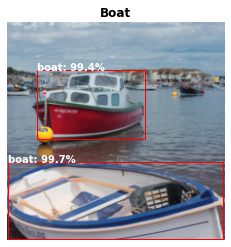

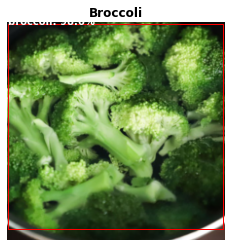

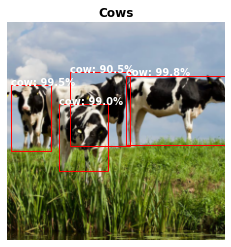

In [12]:
for n, (name, img_tensor) in enumerate(img_name_tensors.items()):
    plt.figure()
    output = model(img_tensor)[0]
    boxes, labels, scores = output['boxes'], output['labels'], output['scores']
    
    # Filter only +80%
    mask = scores > 0.8
    indices = torch.nonzero(mask)
    boxes = boxes[indices]
    labels = labels[indices]
    scores = scores[indices]

    img_tensor_plot = img_tensor.squeeze(0).permute(1, 2, 0)
    plt.imshow(img_tensor_plot)
    plt.axis('off')
    
    for i in range(boxes.size(0)):
        x1, y1, x2, y2 = boxes[i, :].tolist()[0]
        box_w, box_h = x2 - x1, y2 - y1
        rect = plt.Rectangle((x1, y1), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1, f'{coco_labels[labels[i]-1]}: {scores[i].item():0.1%}', fontweight='bold', color='white')
    
    plt.title(name, fontweight='bold')
    plt.show()

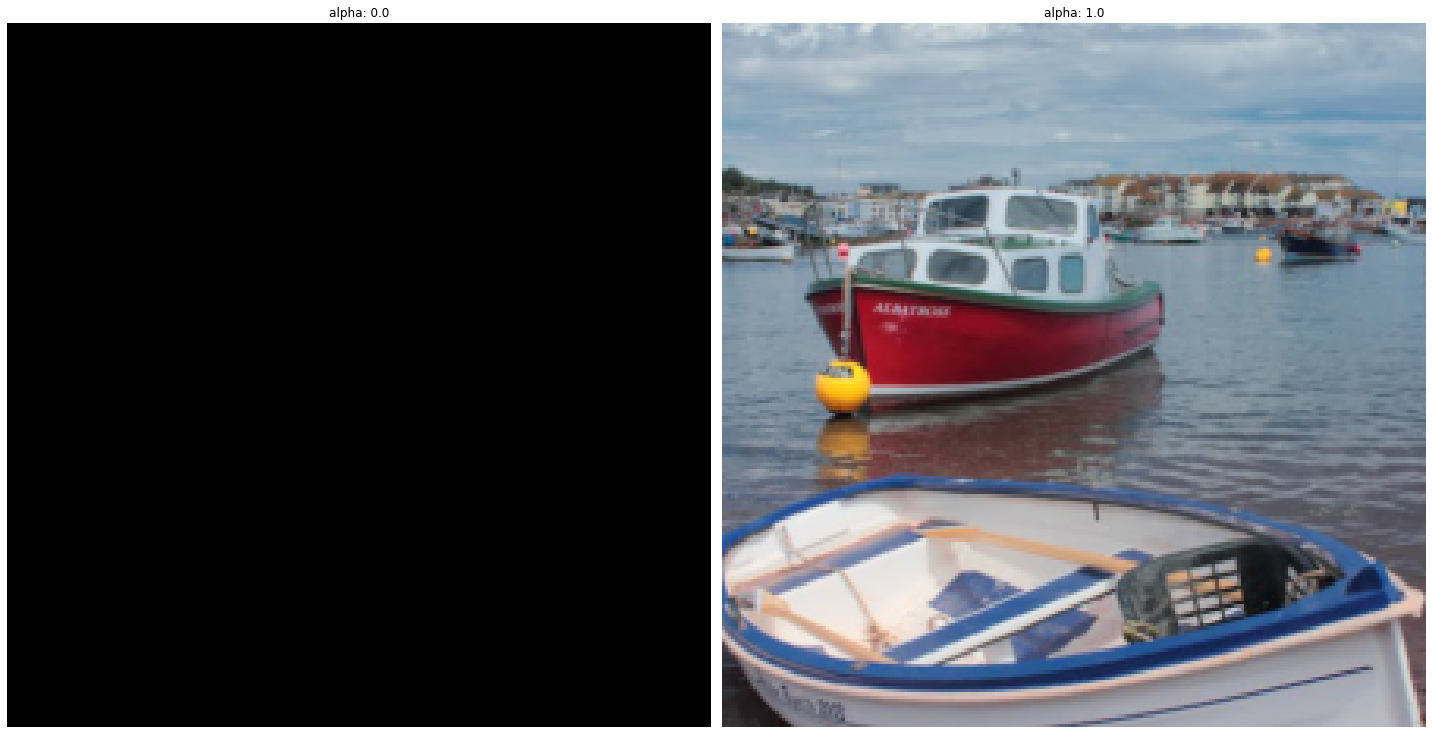

In [13]:
baseline = torch.zeros(size=(224,224,3))
m_steps = 10
alphas = torch.linspace(start=0.0, end=1.0, steps=m_steps+1)

interpolated_images = interpolate_images(baseline=baseline, image=img_name_tensors['Boat'], alphas=alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

In [ ]:
path_gradients = compute_gradients(images=interpolated_images, target_class_idx=20)
print(path_gradients.shape)

In [ ]:
ig = integral_approximation(gradients=path_gradients)
print(ig.shape)

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline, image=img_name_tensors['Boat'], target_class_idx=8, m_steps=55)
print(ig_attributions.shape)

_ = plot_img_attributions(image=img_name_tensors['Boat'], baseline=baseline, target_class_idx=8, m_steps=55, cmap=plt.cm.inferno, overlay_alpha=0.4)